In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import psycopg2
import sys
import datetime as dt
import mp_utils as mp

from sklearn.pipeline import Pipeline

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

from __future__ import print_function

In [3]:
# load in offsets vars
df_offset = pd.read_csv('icustays_with_offset.csv')
df_offset['intime'] = pd.to_datetime(df_offset['intime'])
df_offset['icustay_id'] = df_offset['icustay_id'].astype(int)
df_offset = df_offset.loc[:,['icustay_id','intime','outtime','starttime']]
df_offset.set_index('icustay_id',inplace=True)


df_design = pd.read_csv('design_matrix.csv')
df_design['icustay_id'] = df_design['icustay_id'].astype(int)
df_design.set_index('icustay_id',inplace=True)
df_design.head()

,heartrate_first,systolicbp_first,diastolicbp_first,meanbp_first,resprate_first,temp_first,spo2_first,glucosecharted_first,gcsmotor_first,gcsverbal_first,...,meanbp_max,resprate_max,temp_max,spo2_max,glucosecharted_max,rrt_max,vasopressor_max,vent_max,gcs_max,urineoutput_sum
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,77,105,54,67.000000,25,36.055556,100,NaN,6,5,...,83,28,36.055556,100,NaN,1,0,0,15,NaN
200003,94,106,58,74.000000,34,37.111113,94,90,6,5,...,105,34,37.611109,98,90,0,1,1,15,80
200006,70,111,56,74.333298,18,36.499998,99,71,6,5,...,81,21,36.499998,99,71,NaN,0,1,15,185
200007,97,102,45,64.000000,23,NaN,94,NaN,NaN,NaN,...,64,23,NaN,94,NaN,NaN,0,0,NaN,NaN
200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95,NaN,NaN,...,NaN,NaN,NaN,NaN,136,NaN,0,0,NaN,NaN


In [4]:
# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

# exclusion criteria:
#   - less than 16 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
query = \
"""
with t1 as
(
select ie.icustay_id
    , adm.HOSPITAL_EXPIRE_FLAG
    , ROW_NUMBER() over (partition by ie.subject_id order by intime) as rn
from icustays ie
inner join admissions adm
    on ie.hadm_id = adm.hadm_id
inner join patients pat
    on ie.subject_id = pat.subject_id
    and pat.dob < ie.intime - interval '16' year
where adm.HAS_CHARTEVENTS_DATA = 1
and (ie.outtime - ie.intime) >= interval '4' hour
)
select 
    icustay_id
    , HOSPITAL_EXPIRE_FLAG
from t1
"""
co = pd.read_sql_query(query,con)
co.set_index('icustay_id',inplace=True)

# extract static vars into a separate dataframe
df_static = pd.read_sql_query('select * from mpap_static_vars',con)
for dtvar in ['intime','outtime','deathtime']:
    df_static[dtvar] = pd.to_datetime(df_static[dtvar])
df_static.set_index('icustay_id',inplace=True)

cur.close()
con.close()

The modelling of this data will proceed in two stages:

1. A cross-validation estimate of the performance of the Gradient Boosting Decision Trees (GBDT) model (via xgboost) vs. standard regression models will be reported
2. A single model using *most* of the data (90%) will be created using GBDT - then this model will be qualitatively evaluated on a subset of the held out 10% across their entire stay.

In [54]:
vars_static = [u'male', u'emergency', u'age',
               u'cmed', u'csurg', u'surg', u'nsurg',
               u'surg_other', u'traum', u'nmed',
               u'omed', u'ortho', u'gu', u'gyn', u'ent']

df = co.merge(df_design, how='left', left_index=True, right_index=True)
df = df.merge(df_static[vars_static],how='left', left_index=True, right_index=True)

# move from a data frame into a numpy array
X = df.values.astype(float)
y = X[:,0]

icustay_id = df.index.values

# delete first column: the outcome
X = np.delete(X,0,axis=1)

# get a header row
X_header = [xval for x, xval in enumerate(df.columns) if x > 0]

In [61]:
# create various models in cross-validation
np.random.seed(seed=72397)
models = {'l2logreg': LogisticRegressionCV(penalty='l2',cv=5,fit_intercept=True),
         'lasso': LassoCV(cv=5,fit_intercept=True),
         'xgb': xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05),
         'logreg': LogisticRegression(fit_intercept=True)}

scores = list()
for i, mdl in enumerate(['logreg','l2logreg','lasso','xgb']):
    if mdl == 'xgb':
        # no pre-processing of data necessary
        estimator = Pipeline([(mdl, models[mdl])])
        
    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])])
    
    scores.append(cross_val_score(estimator, X, y, scoring='roc_auc',cv=5))
    
    print('{:10s} - {:0.4f} [{:0.4f}, {:0.4f}]'.format(mdl, np.mean(scores[i]), np.min(scores[i]), np.max(scores[i])))

logreg     - 0.8964 [0.8893, 0.9055]
l2logreg   - 0.8965 [0.8893, 0.9054]
lasso      - 0.8928 [0.8857, 0.9010]
xgb        - 0.9187 [0.9100, 0.9239]


/home/alistairewj/.local/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


In [6]:
# create a single xgb model with just the training set
np.random.seed(seed=324875)
idxTest = np.random.rand(X.shape[0]) > 0.05
X_train = X[~idxTest,:]
y_train = y[~idxTest]
iid_train = icustay_id[~idxTest]

X_test = X[idxTest,:]
y_test = y[idxTest]
iid_test = icustay_id[~idxTest]

In [10]:
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb_model = xgb_model.fit(X_train, y_train)

In [38]:
df.head()

,hospital_expire_flag,heartrate_first,systolicbp_first,diastolicbp_first,meanbp_first,resprate_first,temp_first,spo2_first,glucosecharted_first,gcsmotor_first,...,surg,nsurg,surg_other,traum,nmed,omed,ortho,gu,gyn,ent
icustay_id,,,,,,,,,,,,,,,,,,,,,
211552,0,82,127,57,81,16,36.799999,97,100,6,...,0,0,1,0,0,0,0,0,0,0
294638,0,101,133,73,93,NaN,NaN,95,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
228232,0,83,143,56,85,14,37.444445,95,98,6,...,1,0,0,0,0,0,0,0,0,0
220597,1,101,177,77,101,14,36.055556,100,NaN,1,...,0,0,0,0,1,0,0,0,0,0
229441,0,80,106,56,75,19,NaN,96,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0


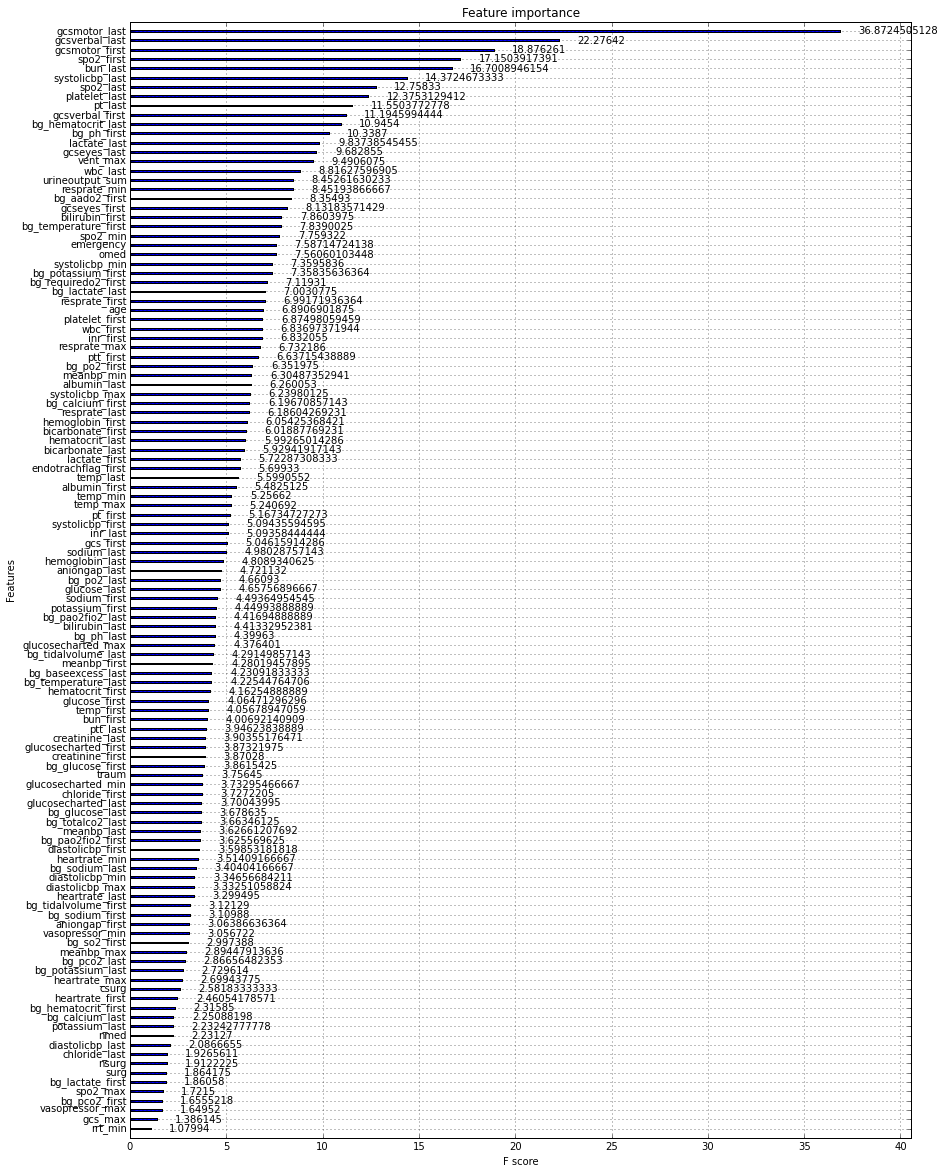

In [37]:
reload(mp)
plt.figure(figsize=[14,20])
ax = plt.gca()
mp.plot_xgb_importance_fmap(xgb_model, X_header=X_header,
                            importance_type='gain', ax=ax)
plt.show()

In [26]:
type(fn)

matplotlib.cbook.silent_list

# Evaluate model on a single patient

Here we:

1. Load data for a single patient from csv
    * this dataframe has patient observations at every charttime
2. Generate a dataframe with the extracted features for every charttime
3. Apply the model to each row of this dataframe
4. Plot the result

In [ ]:
# this prints out three random test cases which we have .csv files for
# we only saved csv files for ICUSTAY_ID < 210000, to save space
iid_test[iid_test < 210000][0:3]

In [106]:
# load in a single individual's data from saved csv files (for convenience)
iid = 209737 # 206719, 203461, 207012
# 202887, 207046, 200806, 205803, 201975, 209108 are metavision patients
df_curr = pd.read_csv('./data/' + str(iid) + '.csv')
df_curr['charttime'] = pd.to_datetime(df_curr['charttime'])

# change charttime into time elapsed
df_curr['timeelapsed'] = (df_curr['charttime'] - df_static.loc[iid,'intime']) / np.timedelta64(1, 'm')
df_curr.set_index('timeelapsed',inplace=True)
df_curr.head()

# this can take ~10-30 seconds to generate the features for all the rows
df_x = mp.extract_feature_across_sp(df_curr)
X_curr = df_x.values.astype(float)

# add in the static variables
X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
X_curr = np.column_stack([X_curr, X_static])

# create the outcome
y_curr = np.tile( co.loc[iid,'hospital_expire_flag'], [X_curr.shape[0],] )

# generate probability for the window selected for this patient
y_prob = xgb_model.predict_proba(X_curr)
y_prob = y_prob[:,1]

# plot this probability over time
t = df_x.index.values/60.0 + 4.0 # convert to hours, add offset so t indexes the *end* time

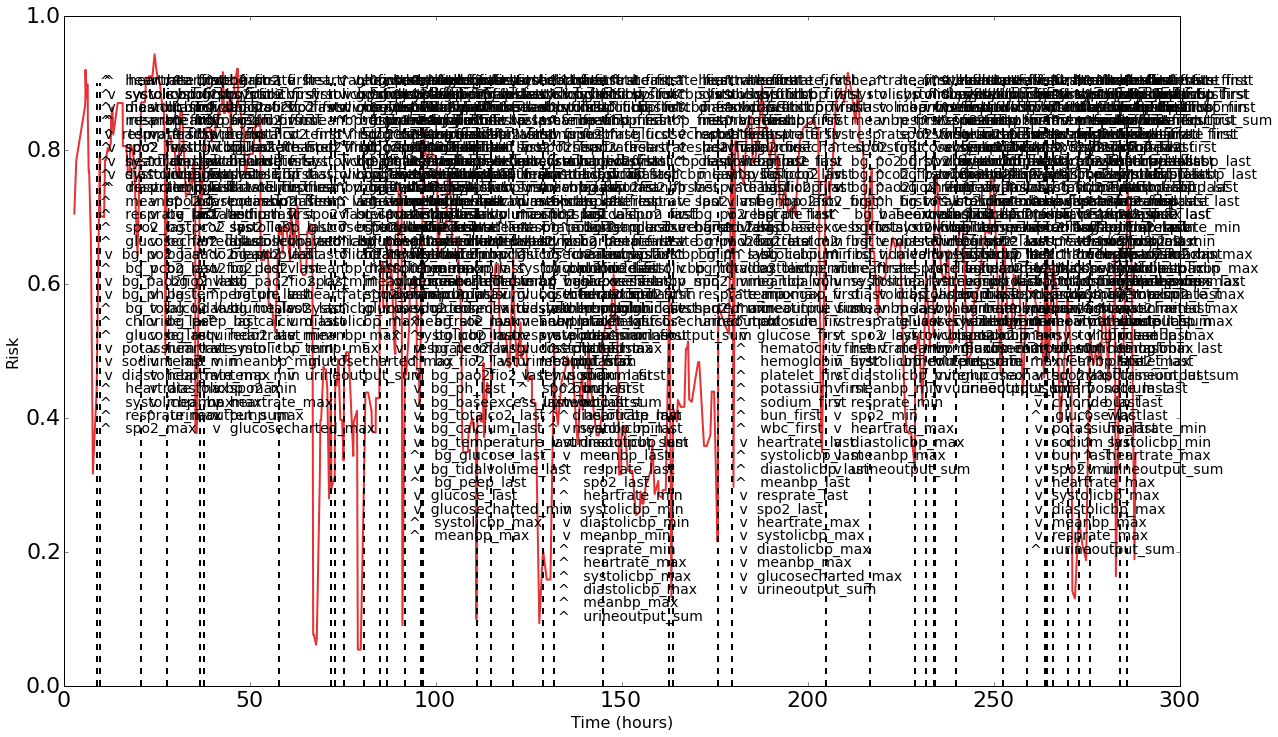

In [107]:
plt.figure(figsize=[20,12])
plt.plot(t,y_prob,'-',color=col[0],linewidth=2)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Risk',fontsize=16)

ax = plt.gca()
ax.set_ylim([0,1])

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

ylim = plt.ylim()

for i, val in enumerate(idxBigJump):
    #print(i, val)
    X_big = X_curr[val,:]
    X_sml = X_curr[val-1,:]
    
    idxDiff = np.where(abs(X_big - X_sml) > 1e-4)[0]
    
    # now look for *big* differences
    
    # get anchors for plot locations
    anchor_x = t[val]
    anchor_y = ylim[1]-0.1*(ylim[1]-ylim[0]) # the higher prob
    
    for m, mval in enumerate(idxDiff):
        if X_big[mval] > X_sml[mval]:
            txt_for_plot = '^   ' + X_header[mval]
        else:
            txt_for_plot = ' v  ' + X_header[mval]
            
        plt.plot([anchor_x, anchor_x], [0.0,0.9], '--', color='k', linewidth=2)
        plt.text(anchor_x+1,anchor_y-(m*0.02),txt_for_plot,fontsize=14)
            
    
plt.show()

In [108]:
# get extra data about treatments/code status
inputs = mp.query_infusions(iid)
inputs['icustarttimehr'] = inputs['icustarttime'] / np.timedelta64(1,'h')
inputs['icuendtimehr'] = inputs['icuendtime'] / np.timedelta64(1,'h')

codestatus = mp.query_codestatus(iid) # takes 2-3 minutes
if codestatus.shape[0]>0:
    codestatus['icutimehr'] = codestatus['icutime'] / np.timedelta64(1,'h')

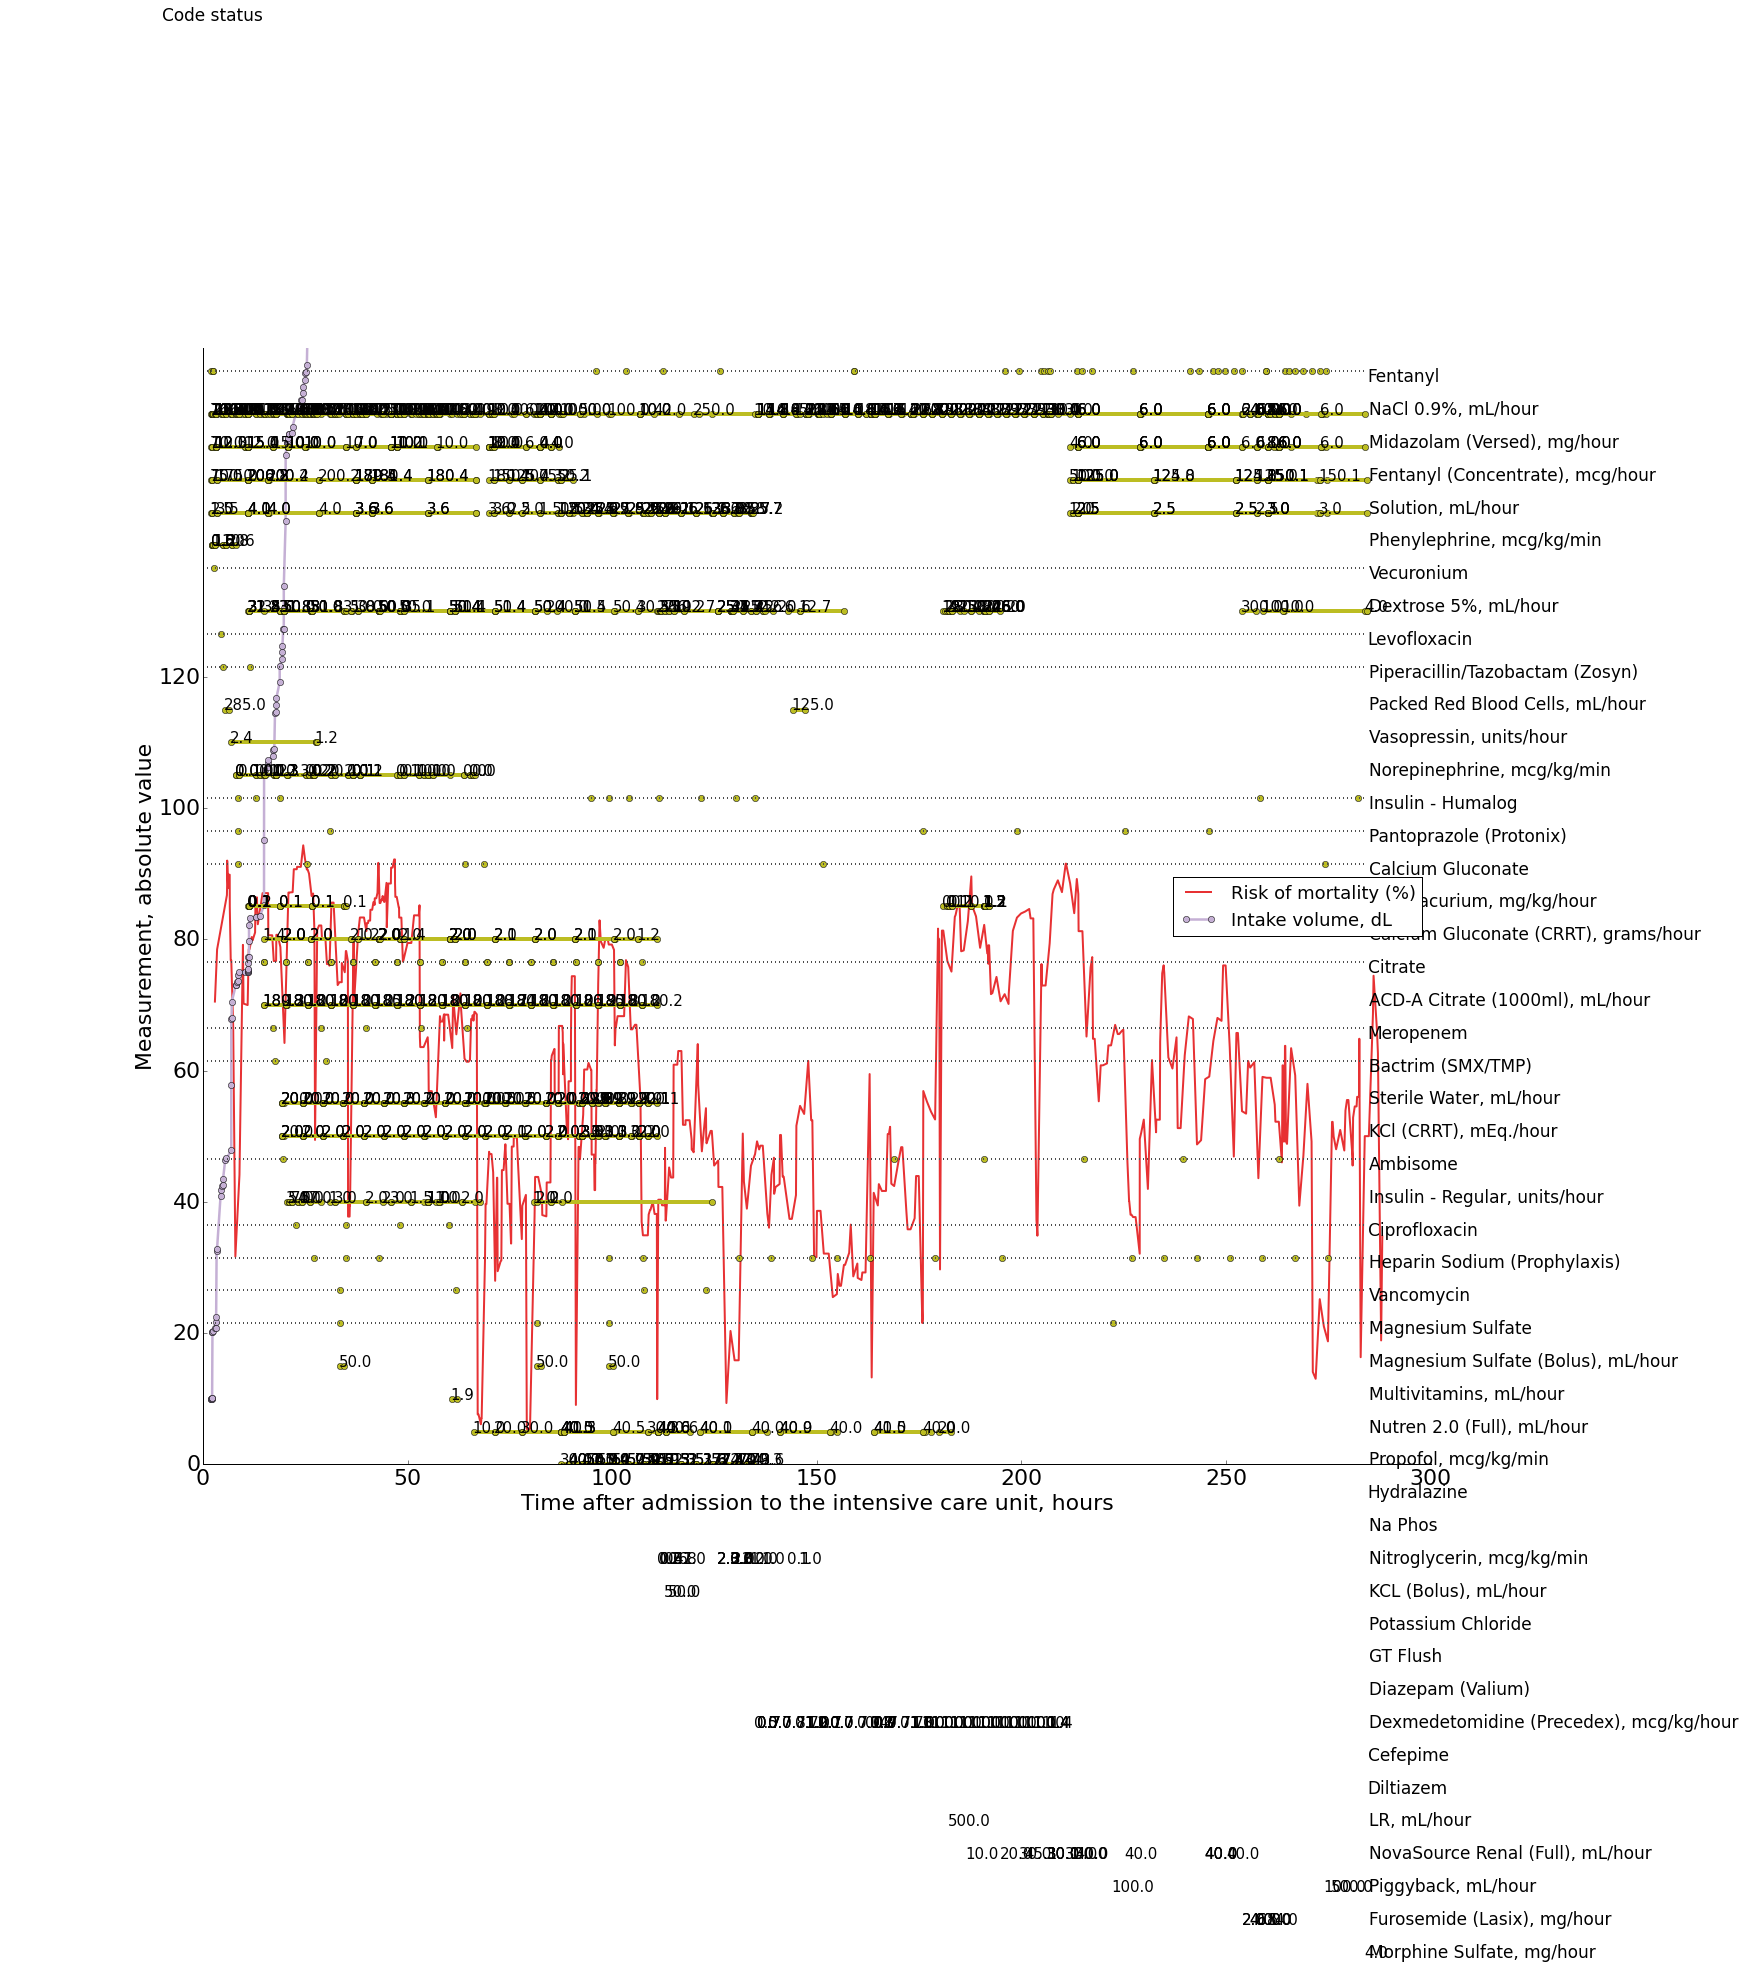

In [112]:
# Plot sample data over first 24 hours from admission to ICU
# Credit: Randal Olson for styling (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. 
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

# Plot risk
plt.plot(t,100.0*y_prob,'-',
         label='Risk of mortality (%)',
         color=col[0],linewidth=2)

# Plot input/output events
plt.plot(inputs.icustarttimehr[inputs.amountuom=='mL'], 
         inputs.amount[inputs.amountuom=='mL'].cumsum()/100, 
         color=tableau20[9], lw=2.5,
         marker='o', markersize=6, label='Intake volume, dL')

#plt.plot(outputs.icutimehr, 
#         outputs.value.cumsum()/100, 
#         color=tableau20[10], lw=2.5,
#         marker='o', markersize=6, label='Output volume, dL')

# Plot intravenous meds

iv_meds = [x for x in inputs.label.unique()
           if x != 'Gastric Meds'
           and x != 'PO Intake']



for m, med in enumerate(iv_meds):
    y_loc = 165-(m*5) # where on the y-axis the data is plotted
    unit = [x for x in inputs.loc[inputs['label']==med,'rateuom'].unique()
        if x != '']
    if len(unit)>0:
        unit = ', ' + str(unit[0])
    else:
        unit = ''
    
    plt.text(np.max(inputs.icuendtimehr)+0.5,y_loc,med + unit,fontsize=17)
    
    
    for i,row in inputs.loc[(inputs["label"] == med) & (inputs["rate"] > 0)].iterrows():
        plt.plot([row['icustarttimehr'],row['icuendtimehr']],[y_loc]*2,
                 color=tableau20[16], lw=4,marker='o', markersize=6)
        plt.text(row['icustarttimehr'], y_loc,
                 str(round(row['rate'],1)),
                 fontsize=15)
        
    if inputs.loc[(inputs["label"] == med) & (inputs["rate"] > 0)].shape[0] == 0:
        plt.plot(inputs.icustarttimehr[inputs.label==med],
                  [y_loc+1.5]*len(inputs[inputs.label==med]),
                  color=tableau20[16], lw=0, marker='o', markersize=6)
        
        # dashed line to guide the eye
        plt.plot([0,np.max(inputs.icuendtimehr)],
                  [y_loc+1.5]*2,
                  color=[0.3,0.3,0.3], lw=2, linestyle=':', markersize=6)

# Plot code status
if codestatus.shape[0]>0:
    plt.text(-10,220,'Code status',fontsize=17) 
    for i, txt in enumerate(codestatus.value[codestatus.label=='Code Status'].values):
            plt.annotate(txt, (codestatus.icutimehr[codestatus.label=='Code Status'].
                               values[i],220),fontsize=17)
        
plt.legend(loc=5,fontsize=18)
plt.xlabel('Time after admission to the intensive care unit, hours', fontsize=22)
plt.ylabel('Measurement, absolute value', fontsize=22)
plt.yticks(np.arange(0, 140, 20))

ax.set_ylim([0,170])
plt.show()

In [ ]:
#pd.DataFrame(X_curr,columns=X_header).to_csv('tmpdata.csv')

In [ ]:
# write a function that, given two times, calculates:
#  - the top 3 features which resulted in a lower risk
#  - the top 3 features which resulted in a higher risk

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

t1 = idxBigJump[0]-1
t2 = idxBigJump[0]

# bonus points for some estimate of the increased risk
def features_changing_risk(X, mdl, t1=0, t2=1):
    X1 = np.reshape(X[t1,:],[1,X.shape[1]])
    X2 = np.reshape(X[t2,:],[1,X.shape[1]])
    
    #print(X1)
    #print(X2)
    y1 = mdl.predict_proba(X1)[0,1]
    y2 = mdl.predict_proba(X2)[0,1]
    print('Pred1: {:0.4f}. Pred2: {:0.4f}.'.format(y1,y2))
    
    # look for any difference
    idxDiff = np.where(abs(X2 - X1) > 1e-4)[1]
    
    # now loop through and look for *big* differences
    diffMagnitude = np.zeros(idxDiff.shape)
    for m, mval in enumerate(idxDiff):
        X_tmp = np.copy(X1)
        X_tmp[0,mval] = X2[0,mval]
        
        y_eval = mdl.predict_proba(X_tmp)
        y_eval = y_eval[0,1]
        
        y_diff = y_eval-y1
        y_diff_pct = (y_eval-y1) / abs(y2-y1) * 100.0
        
        diffMagnitude[m] = y_diff_pct
        print('{:3g} of {:3g} - idx={:3g}'.format(m, len(idxDiff), mval),
              '{:20s} - {:0.4f} vs. {:0.4f}'.format(X_header[mval], y_eval, y1),
              '\t{:1.4f}, {:2.1f}% of the overall change'.format(y_diff, y_diff_pct))
        
    
    sort_indices = np.argsort(diffMagnitude)
    idxDiff = idxDiff[sort_indices]
    if len(idxDiff)<3:
        idxDiff = [idxDiff, np.nan, np.nan]
    
    return idxDiff[0:3]

idxIncreased = features_changing_risk(X_curr, xgb_model, t1=t1, t2=t2)

In [ ]:
# write a function that, given two times, calculates:
#  - the top 3 features which resulted in a lower risk
#  - the top 3 features which resulted in a higher risk

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

t1 = idxBigJump[0]-1
t2 = idxBigJump[0]

# bonus points for some estimate of the increased risk
def feature_importance(X, mdl, t1=0, t2=1):
    X1 = np.reshape(X[t1,:],[1,X.shape[1]])
    X2 = np.reshape(X[t2,:],[1,X.shape[1]])
    
    #print(X1)
    #print(X2)
    y1 = mdl.predict_proba(X1)[0,1]
    y2 = mdl.predict_proba(X2)[0,1]
    print('Pred1: {:0.4f}. Pred2: {:0.4f}.'.format(y1,y2))
    
    # look for any difference
    idxDiff = np.where(abs(X2 - X1) > 1e-4)[1]
    
    # now loop through and look for *big* differences
    diffMagnitude = np.zeros(idxDiff.shape)
    for m, mval in enumerate(idxDiff):
        X_tmp = np.copy(X2)
        X_tmp[0,mval] = X1[0,mval]
        
        y_eval = mdl.predict_proba(X_tmp)
        y_eval = y_eval[0,1]
        
        y_diff = y_eval-y1
        y_diff_pct = (y2-y_eval) / abs(y2-y1) * 100.0
        
        diffMagnitude[m] = y_diff_pct
        print('{:3g} of {:3g} - idx={:3g}'.format(m, len(idxDiff), mval),
              '{:20s} - {:0.4f} vs. {:0.4f}'.format(X_header[mval], y_eval, y1),
              '\t{:1.4f}, {:2.1f}% of the overall change'.format(y_diff, y_diff_pct))
        
    
    sort_indices = np.argsort(diffMagnitude)
    idxDiff = idxDiff[sort_indices]
    if len(idxDiff)<3:
        idxDiff = [idxDiff, np.nan, np.nan]
    
    return idxDiff[0:3]

idxIncreased = feature_importance(X_curr, xgb_model, t1=t1, t2=t2)

In [ ]:
# problem with the above is it's all univariate.. so if we remove/add a single feature, it's not really representative of the change

In [ ]:
# load in a single individual's data from saved csv files (for convenience)
iid = 207012 # 203461, 207012
df_curr = pd.read_csv('./data/' + str(iid) + '.csv')
df_curr['charttime'] = pd.to_datetime(df_curr['charttime'])

# change charttime into time elapsed
df_curr['timeelapsed'] = (df_curr['charttime'] - df_static.loc[iid,'intime']) / np.timedelta64(1, 'm')
df_curr.set_index('timeelapsed',inplace=True)
df_curr.head()

# this can take ~10-30 seconds to generate the features for all the rows
df_x = mp.extract_feature_across_sp(df_curr)
X_curr = df_x.values.astype(float)

# add in the static variables
X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
X_curr = np.column_stack([X_curr, X_static])

# create the outcome
y_curr = np.tile( co.loc[iid,'hospital_expire_flag'], [X_curr.shape[0],] )

# generate probability for the window selected for this patient
y_prob = xgb_model.predict_proba(X_curr)
y_prob = y_prob[:,1]

In [ ]:
# plot this probability over time
t = df_x.index.values # convert to hours

plt.figure(figsize=[9,9])
plt.plot(t,y_prob,'-',color=col[0],linewidth=2)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Risk',fontsize=16)
plt.show()

In [ ]:
df_x.iloc[145:165].T

In [51]:
# this prints out three random test cases which we have .csv files for
# we only saved csv files for ICUSTAY_ID < 210000, to save space
iid_test[iid_test < 210000][40:80]
# 202887, 207046, 200806, 205803, 201975, 209108 are metavision patients

array([201556, 204131, 204405, 205803, 205958, 208601, 201975, 200301,
       205268, 208952, 203404, 200268, 205466, 208041, 208354, 206495,
       201118, 200539, 206015, 202829, 207583, 205870, 201212, 205546,
       208970, 204437, 208434, 207822, 205822, 200561, 201786, 208817,
       206942, 207595, 209529, 203381, 204767, 203785, 202996, 209108])